### Integrantes
<ul>
<li>Sebastián Aranda 201104560-2</li>
<li>Felipe Santander 201104xxx-x</li>
</ul>

# Fronteras de Clasificación

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

In [3]:
n_samples=500

#Generating Multivariate Normal Distribution
mean = (0,-4)
C = np.array([[0.3, 0.1], [0.1, 1.5]])
datos1 = np.random.multivariate_normal(mean, C, n_samples)

#Generating Halfmoon Distribution
outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
datos2 = np.vstack((outer_circ_x,outer_circ_y)).T
generator = check_random_state(10)
datos2 += generator.normal(scale=0.3, size=datos2.shape)

Desribir Dataset

(500, 2)
(500, 2)


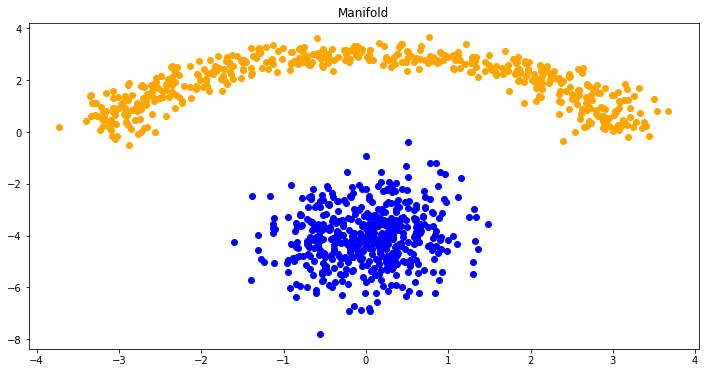

In [15]:
print(datos1.shape)
print(datos2.shape)
#print(datos1.T.shape)
#print(datos1[:,0].shape)
#print(datos1[:,1].shape)

#x,y = datos1.T or x,y = datos1[:,0],datos1[:,1]
x1,y1 = datos1.T
x2,y2 = datos2.T

plt.figure(figsize=(12,6))
plt.plot(x1,y1,'o',color='blue')
plt.plot(x2,y2,'o',color='orange')
plt.title("Manifold")
plt.show()

In [5]:
X = np.concatenate((datos1, datos2), axis=0)
n = 20 #Noise
y1 = np.zeros(datos1.shape[0]+n)
y2 = np.ones(datos2.shape[0]-n)
y = np.concatenate((y1,y2),axis=0)

#print(X.shape)
#print(y.shape)

#plt.plot(X,y)
#plt.show()

In [6]:
import matplotlib.pyplot as plt
def visualize_border(model,x,y,title=""):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

Analizar cualitativamente LDA y QDA, comparar

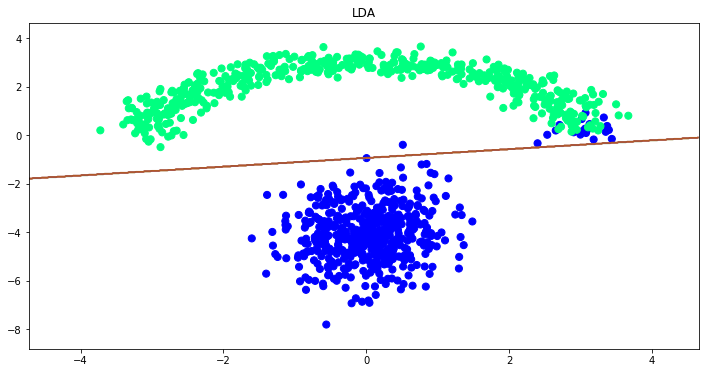

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA()
model.fit(X,y)
visualize_border(model,X,y,"LDA")

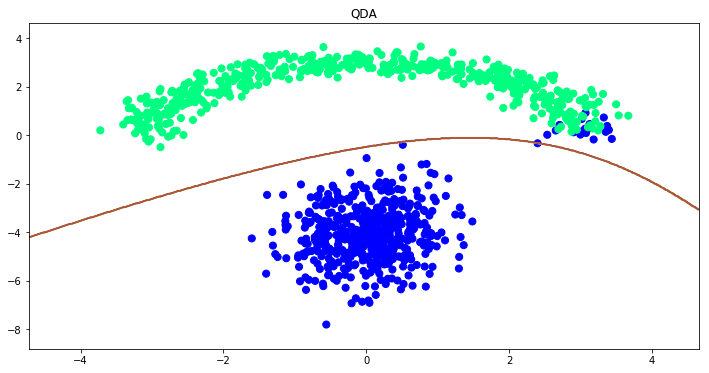

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model = QDA()
model.fit(X,y)
visualize_border(model,X,y,"QDA")

Describir cuantitativamente

In [ ]:
from sklearn.metrics import accuracy_score
print("Miss Classification Loss: %f"%(1-accuracy_score(y_true, y_pred)))

Analizar comportamiento de los parámetros

In [9]:
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X,y)
    
from sklearn.linear_model import LogisticRegression as LR
def train_model(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    model.fit(X,y)
    return model

p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Analizar valores del parámetro de regularización C para SVM lineal

In [10]:
from sklearn.svm import SVC as SVM
#SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='linear')
    model.fit(X,y)
    return model

p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Analizar valores del parámetro de regularización C para SVM no lineal

In [11]:
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='rbf')
    model.fit(X,y)
    return model

p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

In [12]:
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='poly')
    model.fit(X,y)
    return model

p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Analizar valores del parámetro de profundidad del árbol de decisión

In [13]:
from sklearn.tree import DecisionTreeClassifier as Tree
def train_model(param):
    model = Tree()#edit the train_model function
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X,y)
    return model

p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Analizar valores del parámetro de k del algoritmo de clasificación K-NN

In [14]:
from sklearn.neighbors import KNeighborsClassifier
def train_model(param):
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=param)
    model.fit(X,y)
    return model

p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

# Análisis de Audio - Datos Brutos

### <a href="https://www.kaggle.com/kinguistics/heartbeat-sounds">Heartbeat-sounds Kaggle</a>

In [41]:
import pandas as pd
import numpy as np

In [ ]:
from scipy.io import wavfile

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name

SAMPLE_RATE = 44100
def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

In [5]:
df = pd.read_csv('./heartbeat-sounds_dataset/set_a.csv')
df.head()
#df.describe()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [ ]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux

new_df =pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelled')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='path/to/set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series'])

### <a href="https://www.kaggle.com/toregil/new-labels-for-set-a">New labels for set a</a>

Cambiar Labels 

In [ ]:
new_labels =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
             1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0,
             2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0,
             0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels

Cambiar clases a valores numéricos para ser trabajados por los clasificadores

In [ ]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes

In [ ]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape

Se procesa la secuencia de tiempo utilizando una <a href="https://en.wikipedia.org/wiki/Fourier_transform">transformada de fourier discreta</a> para pasar los datos desde el dominio de tiempos al de frecuencias, presentes en la señal de sonido

In [43]:
X_fourier = np.abs(np.fft.fft(X))

Muestreo

In [ ]:
from scipy import signal

X_resampled = []
for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)

X_resampled = np.array(X_resampled)
X_resampled.shape

##### Hold-out Validation

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y,
                                                    test_size=0.25, random_state=42)

#Standarization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

#PCA
from sklearn.decomposition import PCA
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

Construir gráfico de error de entrenamiento y testeo en función del hiper-parámetro de regularización C para un modelo de Regresión Logística y para otro de SVM con kernel lineal

In [ ]:
Cs = [0.0001,0.01,0.1,1,10,100,1000]

Construir gráfico de error de entrenamiento y testeo en función del hiper-parámetro de profundidad de un Árbol de decisión

In [1]:
Depths = range(1,30)

Experimente con diferentes dimensiones <i>d</i> para la proyección de PCA con el propósito de obtener un modelo con menor error. Construya una tabla o grafico resumen

Realice otra reducción de dimensionalidad ahora a través de la técnica LDA, para representar los datos en <i>d</i> = 2 dimensiones. Recuerde que solo se debe ajustar con el conjunto de entrenamiento, si se muestra un warning explique el por qué. Visualice apropiadamente la proyección en 2 dimensiones.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_lda = LDA(n_components=2)
model_lda.fit(X_train,y_train)
X_pca_train = model_lda.transform(X_train)
X_pca_test = model_lda.transform(X_test)

Con el propósito de encontrar el mejor modelo vuelva a realizar el item h) con el i) en el nuevo espacio generado por la representación según las <i>d</i> dimensiones de la proyección LDA. Esta nueva representación ¿mejora o empeora el desempeño? Explique

##### Feature Crafting

# Análisis de Emociones - Twitter

<a href="https://www.crowdflower.com/data-for-everyone/">Crowd Flower</a>